In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def randpoints(num):
    # generate random points in the unit circle
    r = np.random.rand(num)
    theta = 2*np.pi*np.random.rand(num)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return np.array([x, y]).T


In [ ]:
import math
from typing import List, Tuple, Set
from itertools import combinations

class CircleCoverageDP:
    def __init__(self, points: List[Tuple[float, float]], radius: float):
        """
        初始化圓覆蓋問題的動態規劃求解器
        
        Args:
            points: 需要被覆蓋的點的列表，每個點為(x, y)座標
            radius: 圓的半徑
        """
        self.points = points
        self.radius = radius
        self.n = len(points)
        # dp[mask]表示覆蓋mask表示的點集所需的最小圓數
        self.dp = {}
        # 存儲每個狀態的最優解對應的圓心
        self.circles = {}
        # 預計算所有可能的圓心
        self.possible_centers = self._compute_possible_centers()
        
    def distance(self, p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
        """計算兩點之間的距離"""
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    def can_cover(self, center: Tuple[float, float], point: Tuple[float, float]) -> bool:
        """判斷以center為圓心的圓是否能覆蓋point"""
        return self.distance(center, point) <= self.radius
    
    def _find_circle_center(self, p1: Tuple[float, float], p2: Tuple[float, float]) -> List[Tuple[float, float]]:
        """
        找到能同時覆蓋兩個點的圓的圓心
        返回可能的圓心列表（可能有1個或2個）
        """
        # 計算兩點的中點
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        d = self.distance(p1, p2) / 2
        
        # 如果兩點距離超過直徑，則無法覆蓋
        if d > self.radius:
            return []
            
        # 如果兩點重合或距離為0，返回中點
        else:
            return [(mid_x, mid_y)]
    
    def _compute_possible_centers(self) -> List[Tuple[float, float]]:
        """
        預計算所有可能的圓心位置
        策略：考慮所有點對可能形成的圓，以及單個點作為圓心的情況
        """
        centers = set()
        
        # 添加所有點作為可能的圓心
        for p in self.points:
            p = tuple(p)
            centers.add(p)
            
        # 考慮所有點對
        for p1, p2 in combinations(self.points, 2):
            possible_centers = self._find_circle_center(p1, p2)
            centers.update(possible_centers)
            
        return list(centers)
    
    def get_covered_points_mask(self, center: Tuple[float, float]) -> int:
        """
        獲取被指定圓心的圓覆蓋的所有點的位元遮罩
        """
        mask = 0
        for i, point in enumerate(self.points):
            if self.can_cover(center, point):
                mask |= (1 << i)
        return mask
    
    def solve_dp(self, mask: int) -> int:
        """
        遞迴求解動態規劃
        
        Args:
            mask: 當前需要覆蓋的點集的位元遮罩
            
        Returns:
            覆蓋這些點所需的最小圓數
        """
        # 如果沒有點需要覆蓋，返回0
        if mask == 0:
            return 0
            
        # 如果已經計算過，直接返回
        if mask in self.dp:
            return self.dp[mask]
            
        # 初始化為最大值
        min_circles = float('inf')
        best_center = None
        
        # 嘗試所有可能的圓心
        for center in self.possible_centers:
            # 計算這個圓能覆蓋哪些點
            covered = self.get_covered_points_mask(center)
            # 只考慮能覆蓋當前mask中的點的情況
            if covered & mask:
                # 遞迴求解剩餘未覆蓋的點
                remaining = mask & (~covered)
                circles_needed = 1 + self.solve_dp(remaining)
                
                if circles_needed < min_circles:
                    min_circles = circles_needed
                    best_center = center
        
        self.dp[mask] = min_circles
        self.circles[mask] = best_center
        return min_circles
    
    def solve(self) -> List[Tuple[float, float]]:
        """
        求解圓覆蓋問題
        
        Returns:
            圓心位置的列表
        """
        # 初始時所有點都未覆蓋
        initial_mask = (1 << self.n) - 1
        
        # 求解最小圓數
        min_circles = self.solve_dp(initial_mask)
        
        # 重建解
        result = []
        current_mask = initial_mask
        while current_mask:
            center = self.circles[current_mask]
            result.append(center)
            # 更新未覆蓋的點集
            covered = self.get_covered_points_mask(center)
            current_mask &= (~covered)
            
        return result

In [46]:
import math
import random
from typing import List, Tuple, Set

class CircleCoverageGreedy:
    def __init__(self, points: List[Tuple[float, float]], radius: float):
        """
        初始化圓覆蓋問題求解器
        
        Args:
            points: 需要被覆蓋的點的列表，每個點為(x, y)座標
            radius: 圓的半徑
        """
        self.points = points
        self.radius = radius
        
    def distance(self, p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
        """計算兩點之間的距離"""
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    def can_cover(self, center: Tuple[float, float], point: Tuple[float, float]) -> bool:
        """判斷以center為圓心的圓是否能覆蓋point"""
        return self.distance(center, point) <= self.radius
    
    def find_circle_center(self, p1: Tuple[float, float], p2: Tuple[float, float]) -> Tuple[float, float]:
        """
        找到能同時覆蓋兩個點的圓的圓心
        假設圓剛好經過這兩個點，返回圓心位置
        """
        # 計算兩點的中點
        mid_x = (p1[0] + p2[0]) / 2
        mid_y = (p1[1] + p2[1]) / 2
        
        # 如果兩點之間的距離大於直徑，則無法用一個圓覆蓋
        if self.distance(p1, p2) > 2 * self.radius:
            return None
        
        # 如果兩點重合或者距離為0，返回中點
        if p1 == p2 or self.distance(p1, p2) == 0:
            return (mid_x, mid_y)
            
        # 計算圓心到中點的垂直距離
        d = self.distance(p1, p2) / 2
        h = math.sqrt(self.radius**2 - (d**2))
        
        # 計算單位向量
        dx = (p2[0] - p1[0]) / self.distance(p1, p2)
        dy = (p2[1] - p1[1]) / self.distance(p1, p2)
        
        # 返回其中一個可能的圓心（另一個在對稱的位置）
        center_x = mid_x - h * dy
        center_y = mid_y + h * dx
        
        return (center_x, center_y)
    
    def get_covered_points(self, center: Tuple[float, float]) -> Set[int]:
        """獲取被指定圓心的圓覆蓋的所有點的索引"""
        covered = set()
        for i, point in enumerate(self.points):
            if self.can_cover(center, point):
                covered.add(i)
        return covered
    
    def solve(self) -> List[Tuple[float, float]]:
        """
        求解圓覆蓋問題
        
        Returns:
            圓心位置的列表
        """
        n = len(self.points)
        if n == 0:
            return []
        
        # 複製一份點的索引，用於追踪未覆蓋的點
        uncovered = set(range(n))
        circles = []
        
        while uncovered:
            best_center = None
            max_coverage = set()
            
            # 遍試所有可能的點對
            for i in uncovered:
                for j in range(n):
                    p1 = tuple(self.points[i])
                    p2 = tuple(self.points[j])
                    
                    center = self.find_circle_center(p1, p2)
                    if center is None:
                        continue
                        
                    # 計算這個圓能覆蓋多少未覆蓋的點
                    coverage = self.get_covered_points(center) & uncovered
                    
                    if len(coverage) > len(max_coverage):
                        max_coverage = coverage
                        best_center = center
            
            if best_center is None:
                # 如果找不到合適的圓心，就直接用一個點作為圓心
                p = self.points[uncovered.pop()]
                circles.append(p)
            else:
                # 添加找到的最佳圓心
                circles.append(best_center)
                uncovered -= max_coverage
                
        return circles

# 測試代碼

In [47]:
points = randpoints(10)
solver = CircleCoverageDP(points, 0.2)
# solver = CircleCoverageGreedy(points, 0.2)
circles = solver.solve()

initial_mask: 0b1111111111


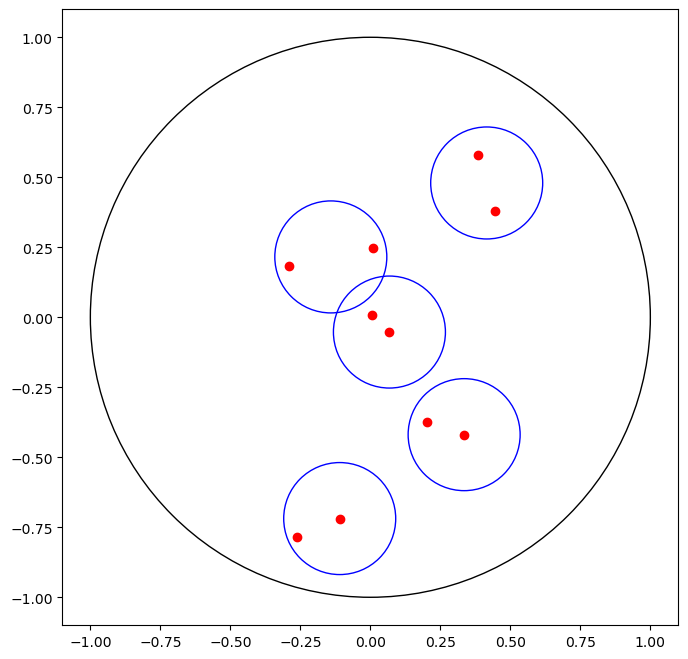

In [42]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, aspect='equal')
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(circle)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.scatter(*points.T, color='r')
for center in circles:
    circle = plt.Circle(center, 0.2, color='blue', fill=False)
    ax.add_artist(circle)